In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)

In [2]:
class MC_ES():
    
    def __init__(self, shape=(21, 10, 2, 2)):
        
        # q_value : 4d array,  state-action pairs
        # hand_sum * dealer_show * usable_ace * action(hit or stick) => 21 * 10 * 2 * 2
        self.q_values = np.zeros(shape)
        self.n_visits = np.copy(self.q_values)
        self.update_policy()
        self.reset()
        
    def update_policy(self):
        # policy : 3d array, boolean value (hit or stick) for each state
        # hand_sum * dealer_show * usable_ace => 21 * 10 * 2
        self.policy = np.argmax(self.q_values, axis=len(self.q_values.shape)-1)
    
    def action(self, state):
        # exploration start
        if self.start:
            self.start = False
            return np.random.choice([0,1])
        else:
            return self.policy[state]
    
    def learn(self, state_actions, returns):
        
        for (s, a), r in zip(state_actions, returns):
            
            index = *s,a
            self.n_visits[index] += 1
            #visits = self.n_visits[index]
            #self.q_values[index] = (visits-1)/visits * self.q_values[index] + 1/visits * r
            
            self.q_values[index] += (1/self.n_visits[index]) * (r - self.q_values[index])
            
        self.update_policy()
    
    def reset(self):
        self.start = True

In [3]:
def episode(env, agent, es=True):
    
    if es:
        agent.reset()
    else:
        agent.start = False
    state = env.reset()
    
    # hit immediately if sum < 11
    if state[0] < 11:
        state = env.step(True)[0]
    
    state_actions = []
    rewards = []
    
    # play a full game
    while (True):
        
        state = (
                 state[0]-11, # hand_sum, range 11-32 -> 0 - 21
                 state[1]-1,  # dealer_show, range 1-10 -> 0-9
                 int(state[2]) # usable ace, Bool -> 0 or 1
                )
        
        action = agent.action(state)
        state_actions.append((state, action))
        
        state, reward, done, _ = env.step(action)
        rewards.append(reward)
        
        # end episode
        if done:
            break
    
    return state_actions, rewards

In [4]:
EPISODES = 100000
GAMMA = 0.9
env = gym.make('Blackjack-v0')
agent = MC_ES()
mean_rewards = []

for i in range(EPISODES):
    
    state_actions, rewards = episode(env, agent)
            
    g = 0
    returns = []
    for reward in rewards[::-1]:                    # <- NOT COMPLETE to 1st state visit yet, but blackjack is one-way
        g = GAMMA * g + reward
        returns.insert(0, g)
    
    #print(state_actions)
    #print(returns)
    
    agent.learn(state_actions, returns)

    
    if i % 100 == 0:
        rewards = [episode(env, agent, es=False)[1][-1] for _ in range(500)]
        mean_rewards.append(sum(rewards) / len(rewards))

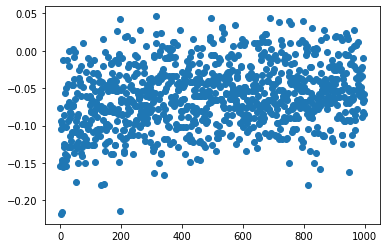

In [5]:
# plotting payoff vs. episodes trained

plt.scatter(range(len(mean_rewards)), mean_rewards);

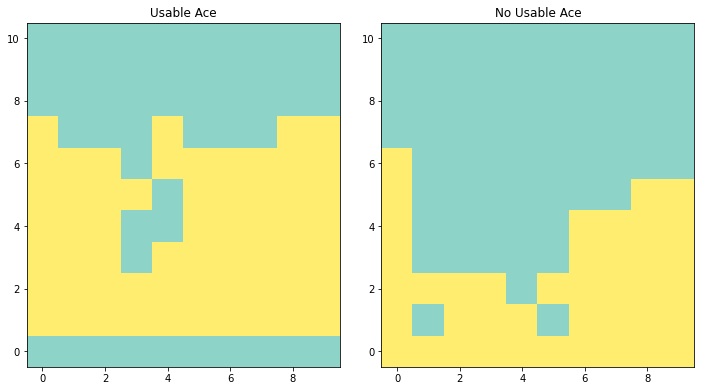

In [6]:
# plotting policy

fig, axs = plt.subplots(1,2, figsize=(10,10))
fig.tight_layout()
axs[0].imshow(agent.policy[:11,:,1], cmap='Set3', origin='lower');
axs[0].set_title("Usable Ace");
axs[1].imshow(agent.policy[:11,:,0], cmap='Set3', origin='lower');
axs[1].set_title("No Usable Ace");

# => figure 5.2 in Sutton & Barto

In [7]:
agent.q_values

array([[[[-7.647e-01, -1.689e-01],
         [ 0.000e+00,  0.000e+00]],

        [[-3.519e-01,  2.857e-01],
         [ 0.000e+00,  0.000e+00]],

        [[-2.915e-01,  1.992e-01],
         [ 0.000e+00,  0.000e+00]],

        [[-2.193e-01,  2.513e-01],
         [ 0.000e+00,  0.000e+00]],

        [[-1.639e-01,  3.116e-01],
         [ 0.000e+00,  0.000e+00]],

        [[-1.574e-01,  2.532e-01],
         [ 0.000e+00,  0.000e+00]],

        [[-4.113e-01,  2.553e-01],
         [ 0.000e+00,  0.000e+00]],

        [[-5.234e-01,  1.005e-01],
         [ 0.000e+00,  0.000e+00]],

        [[-5.676e-01,  2.048e-01],
         [ 0.000e+00,  0.000e+00]],

        [[-5.891e-01,  4.278e-02],
         [ 0.000e+00,  0.000e+00]]],


       [[[-7.525e-01, -5.312e-01],
         [-8.947e-01, -1.929e-01]],

        [[-2.325e-01, -2.983e-01],
         [-4.118e-01,  4.468e-02]],

        [[-2.759e-01, -1.953e-01],
         [-3.333e-01, -4.235e-02]],

        [[-2.386e-01, -1.546e-01],
         [-1.000e-01,  2.44